# Importazione librerie

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
import numpy as np
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
from typing import Callable

In [91]:
pd.options.display.max_columns = None

In [92]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Function

In [93]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [94]:
def compute_last_local_max(series: pd.Series) -> pd.Series:
    """
    Per ogni indice i, restituisce il valore (non l'indice) dell’ultimo massimo locale
    avvenuto in un giorno j < i, con definizione:
    
    - j=0 è un massimo locale se series[0] > series[1].
    - per 0 < j < len(series)-1, j è massimo locale se:
        series[j] >= series[j-1] e series[j] >= series[j+1]
    - l’ultimo giorno (j = len-1) non viene considerato un massimo locale.
    
    Ritorna una Series 'last_local_max' tale che:
       last_local_max[i] = series[j]  (dove j è l’ultimo massimo locale con j < i)
       se non esiste j < i che sia un massimo locale, last_local_max[i] = NaN
    """
    arr = series.values
    n = len(arr)
    
    # Array booleana per marcare i massimi locali
    is_local_max = np.zeros(n, dtype=bool)
    
    if n == 1:
        # Con un solo punto non si può definire un massimo locale nel senso classico.
        # Ritorniamo una serie di NaN.
        return pd.Series([np.nan], index=series.index)
    
    # Controllo per il primo indice
    if arr[0] > arr[1]:
        is_local_max[0] = True
    
    # Controllo per l'intervallo [1..n-2]
    # (l'ultimo indice n-1 non si considera per la definizione di massimo locale)
    for i in range(1, n-1):
        if arr[i] >= arr[i-1] and arr[i] >= arr[i+1]:
            is_local_max[i] = True
    
    # Costruiamo la serie che, per ogni i, dice "valore dell'ultimo max locale avvenuto prima di i"
    last_local_max = np.full(n, np.nan)
    
    last_max_value = np.nan
    
    for i in range(n):
        # Se i è un massimo locale, aggiorniamo last_max_value
        if is_local_max[i]:
            last_max_value = arr[i]
        
        last_local_max[i] = last_max_value
    
    return pd.Series(last_local_max, index=series.index)

In [95]:
def liquidity_out_function(current_liquidity: float, coef_liquidity_out:float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando 
    TUTTE le crypto sono in discesa (M.A. < ultimo max locale).
    Aumentiamo la liquidità in base al modulo della variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    new_liquidity = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

In [96]:
def liquidity_in_function(current_liquidity: float, coef_liquidity_in: float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando
    ALMENO UNA crypto è in salita (M.A. >= ultimo max locale).
    Riduciamo la liquidità in base alla variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    # if variation_percent_ma in [0, None] and coef_liquidity_in == np.inf:
    #     return 0
    
    new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

In [97]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

# Strategia

In [98]:
def portfolio_value(prices_row: pd.Series, quantities_dict: dict, liquidity_amount: float) -> float:
    """
    Calcola il valore totale del portafoglio (sommando le crypto e la liquidità).
    """
    total = liquidity_amount
    for c in quantities_dict.keys():
        total += quantities_dict[c] * prices_row[c]
    return total

In [99]:
def trova_massimi_minimi_locali(series: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dati i valori di 'series', individua i massimi e minimi locali secondo la regola:
    
    - Per i = 0 (primo elemento), se series[0] > series[1], allora series[0] è un massimo locale.
      Se series[0] <= series[1], allora series[0] è un minimo locale.
    - Per 0 < i < len(series) - 1:
        * massimi se series[i-1] < series[i] > series[i+1]
        * minimi se series[i-1] > series[i] < series[i+1]
    - L'ultimo elemento (i = len(series)-1) non viene considerato per definizione.
    
    Ritorna due pd.Series (massimi, minimi) dove i valori sono NaN se non è un estremo locale,
    oppure il valore della series se è un massimo/minimo locale.
    """
    n = len(series)
    
    massimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    minimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    
    if n == 0 or n == 1:
        # Con un solo punto o nessuno, non possiamo definire un massimo o minimo locale
        return massimi, minimi
    
    # Gestione del primo elemento (i=0)
    if n >= 2:
        if series.iloc[0] > series.iloc[1]:
            massimi.iloc[0] = series.iloc[0]
        else:
            minimi.iloc[0] = series.iloc[0]
    
    # Gestione degli elementi intermedi (1 .. n-2)
    for i in range(1, n-1):
        if (series.iloc[i-1] < series.iloc[i] > series.iloc[i+1]):
            massimi.iloc[i] = series.iloc[i]
        elif (series.iloc[i-1] > series.iloc[i] < series.iloc[i+1]):
            minimi.iloc[i] = series.iloc[i]
    
    # L'ultimo elemento (i = n-1) non lo consideriamo come massimo o minimo locale
    
    return massimi, minimi

In [100]:
def trova_ultimo_estremo_locale(series: pd.Series,
                               massimi: pd.Series,
                               minimi: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dato un vettore 'series' e i suoi 'massimi' e 'minimi' locali (come restituiti da
    trova_massimi_minimi_locali), costruisce due Series:
      - last_ext_type: 'max' o 'min' (oppure None/NaN se non c'è stato ancora un estremo)
      - last_ext_value: valore dell'ultimo estremo locale incontrato finora (NaN se nessuno)
    
    Esempio: per i=0, last_ext_type[0] è 'max' se massimi[0] non è NaN, 
             'min' se minimi[0] non è NaN, altrimenti None.
    """
    n = len(series)
    last_ext_type_arr = [None]*n
    last_ext_value_arr = [None]*n
    
    current_type = None
    current_value = None
    
    for i in range(n):
        if not pd.isna(massimi.iloc[i]):
            current_type = 'max'
            current_value = massimi.iloc[i]
        elif not pd.isna(minimi.iloc[i]):
            current_type = 'min'
            current_value = minimi.iloc[i]
        
        last_ext_type_arr[i] = current_type
        last_ext_value_arr[i] = current_value
    
    last_ext_type = pd.Series(last_ext_type_arr, index=series.index, dtype=object)
    last_ext_value = pd.Series(last_ext_value_arr, index=series.index, dtype=float)
    return last_ext_type, last_ext_value

In [101]:
def func_liquidity_out(current_liquidity: float,
                           coef_liquidity_out: float,
                           variation_percent_ma: float) -> float:
    """
    Aumenta la liquidità in base al coefficiente e alla variazione percentuale (assoluta).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_out == np.inf and variation_percent_ma == 0:
        return 1

    new_liquidity_pct = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    return min(max(new_liquidity_pct, 0), 1)

In [102]:
def func_liquidity_in(current_liquidity: float,
                          coef_liquidity_in: float,
                          variation_percent_ma: float) -> float:
    """
    Riduce la liquidità in base al coefficiente e alla variazione percentuale (positiva).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_in == np.inf and variation_percent_ma == 0:
        return 0

    new_liquidity_pct = current_liquidity - coef_liquidity_in * variation_percent_ma
    return min(max(new_liquidity_pct, 0), 1)

In [103]:
def param_str(x):
    """Restituisce il nome se x è una funzione, altrimenti la stringa normale."""
    if callable(x):
        return x.__name__  # così vedrò "ma_prices", "mstd_returns_prices", ecc.
    return str(x)

def grid_search_rebalancing(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        global mini_grid_search_activated
        mini_grid_search_activated = False # Ho dovuto creare 2 function distinte grid_search_rebalancing e mini_grid_search_rebalancing perchè in quella mini devo lasciare mini_grid_search_activated com'è, mentre nella grid search normale è importante reinizializzare mini_grid_search_activated a False prima di ogni combinazione che testo
        display_dict = {k: param_str(v) for k,v in params.items()}
        print(f"\nInizio iterazione {idx+1}/{len(grid_params)}")
        print(f"Parametri: {display_dict}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy( # type: ignore
                dati,
                initial_liquidity,
                initial_allocations,
                params['timeframe'],
                params['timeframe_grid_search'],
                params['mobile_window'],
                params['weighting_factor'],
                params['coef_liquidity_out'],
                params['coef_liquidity_in'],
                params['dynamical_variables'],
                params['window_grid_search'],
                params['func_monitor']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}\n")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df


def mini_grid_search_rebalancing(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        display_dict = {k: param_str(v) for k,v in params.items()}
        print(f"\nInizio iterazione {idx+1}/{len(grid_params)}")
        print(f"Parametri: {display_dict}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy( # type: ignore
                dati,
                initial_liquidity,
                initial_allocations,
                params['timeframe'],
                params['timeframe_grid_search'],
                params['mobile_window'],
                params['weighting_factor'],
                params['coef_liquidity_out'],
                params['coef_liquidity_in'],
                params['dynamical_variables'],
                params['window_grid_search'],
                params['func_monitor']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}\n")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df

In [104]:
# Funzione che calcola la media mobile delle variazioni percentuali dei prezzi
def ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la media mobile delle variazioni percentuali dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = MA delle variazioni percentuali medie
      - per ogni crypto c: 'metric_{c}' = MA delle variazioni percentuali di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo media mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile delle variazioni percentuali dei prezzi
def mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la deviazione standard mobile delle variazioni percentuali dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = std mobile delle variazioni percentuali medie
      - per ogni crypto c: 'metric_{c}' = std mobile delle variazioni percentuali di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile dei prezzi
def ma_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la media mobile dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = MA media tra tutte le crypto
      - per ogni crypto c: 'metric_{c}' = MA del prezzo di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo media mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).mean()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile dei prezzi
def mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la deviazione standard mobile dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = std mobile media tra tutte le crypto
      - per ogni crypto c: 'metric_{c}' = std mobile del prezzo di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della deviazione standard mobile dei prezzi
def mstd_mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std().rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della deviazione standard mobile delle variazioni percentuali dei prezzi
def mstd_mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std().rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della media mobile delle variazioni percentuali dei prezzi
def mstd_ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean().rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della deviazione standard mobile delle variazioni percentuali dei prezzi
def ma_mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std().rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della media mobile dei prezzi
def mstd_ma_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).mean().rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della deviazione standard mobile dei prezzi
def ma_mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std().rolling(window=window).mean()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

## Strategia principale

In [105]:
def simulate_trading_strategy(
    crypto_prices: pd.DataFrame,
    initial_liquidity: float,
    initial_allocations: dict,
    timeframe: int,
    timeframe_grid_search: int,
    mobile_window: int,
    weighting_factor: float,
    coef_liquidity_out: float,
    coef_liquidity_in: float,
    dynamical_variables: dict,
    window_grid_search: int,
    func_monitor: Callable
) -> pd.DataFrame:
    """
    Simula una strategia di trading su un insieme di crypto. Logica:
      (stessa descrizione di prima, invariata)
    """
    global mini_grid_search_activated # Variabile di supporto, non è un parametro della strategia

    if timeframe_grid_search == -1:
        timeframe_grid_search = timeframe

    # =========== PRECALCOLI UNA TANTUM ===========

    # 1) Calcoliamo le metriche con la function specificata
    monitor_df = func_monitor(crypto_prices, mobile_window).copy()
    monitor_df.sort_index(inplace=True)  # Sort una volta sola

    # 2) Troviamo massimi/minimi locali su 'avg_metric'
    massimi_avg, minimi_avg = trova_massimi_minimi_locali(monitor_df['avg_metric'])
    ltype_avg, lval_avg = trova_ultimo_estremo_locale(monitor_df['avg_metric'], massimi_avg, minimi_avg)
    monitor_df["last_ext_type_avg"] = ltype_avg
    monitor_df["last_ext_value_avg"] = lval_avg

    # 3) Per ogni crypto, troviamo massimi/minimi su 'metric_{crypto}'
    crypto_list = list(crypto_prices.columns)
    for c in crypto_list:
        mc = f"metric_{c}"
        massimi_c, minimi_c = trova_massimi_minimi_locali(monitor_df[mc])
        lt_c, lv_c = trova_ultimo_estremo_locale(monitor_df[mc], massimi_c, minimi_c)
        monitor_df[f"last_ext_type_{c}"] = lt_c
        monitor_df[f"last_ext_value_{c}"] = lv_c

    # 4) 'sub_metric_up'
    up_bool_df = pd.DataFrame(False, index=monitor_df.index, columns=crypto_list)
    for c in crypto_list:
        up_bool_df[c] = (monitor_df[f"last_ext_type_{c}"] == 'min')

    arr_metrics = monitor_df[[f"metric_{c}" for c in crypto_list]].values
    arr_up_bool = up_bool_df.values

    sum_up = (arr_metrics * arr_up_bool).sum(axis=1)
    count_up = arr_up_bool.sum(axis=1)

    sub_metric_up = np.full(len(monitor_df), np.nan, dtype=float)
    with np.errstate(invalid='ignore', divide='ignore'):
        sub_metric_up = sum_up / count_up
    monitor_df["sub_metric_up"] = sub_metric_up

    monitor_df["sub_return_up"] = pd.Series(sub_metric_up, index=monitor_df.index).pct_change()
    monitor_df["MA_sub_return_up"] = monitor_df["sub_return_up"].rolling(window=mobile_window).mean()

    massimi_sub, minimi_sub = trova_massimi_minimi_locali(monitor_df["MA_sub_return_up"])
    ltype_sub, lval_sub = trova_ultimo_estremo_locale(monitor_df["MA_sub_return_up"], massimi_sub, minimi_sub)
    monitor_df["last_ext_type_sub_up"] = ltype_sub
    monitor_df["last_ext_value_sub_up"] = lval_sub

    # Rename per comodità
    prices_df = monitor_df  # useremo 'prices_df' nel loop

    # =========== INIZIALIZZAZIONE PORTAFOGLIO ===========

    if 'liquidity' not in initial_allocations:
        initial_allocations['liquidity'] = 0.0

    s_ = sum(initial_allocations.values())
    if not np.isclose(s_, 1.0, atol=1e-7):
        if abs(s_ - 1.0) > 1e-3:
            raise ValueError(f"La somma delle allocazioni iniziali deve essere ~1.0, invece e' {s_}")
        # Rinormalizziamo
        for k in initial_allocations:
            initial_allocations[k] /= s_

    crypto_alloc = [k for k in initial_allocations if k.lower() != "liquidity"]
    if not np.isclose(sum(initial_allocations.values()), 1.0):
        raise ValueError("Allocazioni non sommano a 1.0")

    current_quantities = {c: 0.0 for c in crypto_alloc}
    current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0.0)
    if np.isclose(current_liquidity, 0.0):
        current_liquidity = 0.0

    # Prezzi/metrica del primo giorno
    first_date = prices_df.index[0]
    first_row = prices_df.loc[first_date, crypto_alloc]
    for c in crypto_alloc:
        perc = initial_allocations[c]
        p = first_row[c]
        cap = initial_liquidity * perc
        if pd.notna(p) and p != 0:
            current_quantities[c] = cap / p
        else:
            current_quantities[c] = 0.0

    # =========== LOOP PRINCIPALE ============

    records = []
    idx_array = prices_df.index.to_list()
    N = len(idx_array)

    for i, dt in enumerate(idx_array):
        # Preleviamo con un'unica operazione la riga
        row_data = prices_df.iloc[i]
        row_prices = row_data[crypto_alloc]  # prezzi/valori di c in questa riga
        pv = portfolio_value(row_prices, current_quantities, current_liquidity)

        if np.isclose(current_liquidity, 0.0):
            current_liquidity = 0.0

        # Creiamo il record
        rec = {
            "timestamp": dt,
            "liquidity": current_liquidity,
            "portfolio_value": pv,
            "avg_metric":         row_data["avg_metric"],
            "sub_metric_up":      row_data["sub_metric_up"],
            "sub_return_up":      row_data["sub_return_up"],
            "MA_sub_return_up":   row_data["MA_sub_return_up"],
        }
        for c in crypto_alloc:
            price_c = row_prices[c]
            qty_c   = current_quantities[c]
            rec[f"price_{c}"] = price_c
            rec[f"qty_{c}"]   = qty_c
            rec[f"value_{c}"] = (price_c * qty_c) if pd.notna(price_c) else np.nan

            rec[f"metric_{c}"]          = row_data[f"metric_{c}"]
            rec[f"last_ext_type_{c}"]   = row_data[f"last_ext_type_{c}"]
            rec[f"last_ext_value_{c}"]  = row_data[f"last_ext_value_{c}"]

        rec["last_ext_type_avg"]    = row_data["last_ext_type_avg"]
        rec["last_ext_value_avg"]   = row_data["last_ext_value_avg"]
        rec["last_ext_type_sub_up"] = row_data["last_ext_type_sub_up"]
        rec["last_ext_value_sub_up"] = row_data["last_ext_value_sub_up"]

        records.append(rec)

        # print('Ora mini_grid_search_activated vale:', mini_grid_search_activated)
        # =========== Ribilanciamento =============
        if i > 0 and i % timeframe == 0 and not mini_grid_search_activated or i > 0 and i % timeframe_grid_search == 0 and mini_grid_search_activated:
            # [A] Grid search dinamica (se serve)
            if dynamical_variables:
                print("Valore attuale del portafoglio totale:", pv)
                local_dynvars = deepcopy(dynamical_variables)
                default_parameters = {
                    'coef_liquidity_in': coef_liquidity_in,
                    'coef_liquidity_out': coef_liquidity_out,
                    'dynamical_variables': {},
                    'func_monitor': func_monitor,
                    'mobile_window': mobile_window,
                    'timeframe': timeframe,
                    'timeframe_grid_search': timeframe_grid_search, # Anzichè passare lo stesso timeframe della strategia principale, nella mini grid search passo più in generale timeframe_grid_search
                    'weighting_factor': weighting_factor,
                    'window_grid_search': window_grid_search
                }
                for pname in default_parameters:
                    if pname not in local_dynvars:
                        local_dynvars[pname] = [default_parameters[pname]]
                if len(local_dynvars) != len(default_parameters):
                    raise ValueError("dynamical_variables ha feature inesistenti.")
                
                sort_quantity = 'fattore_rendimento_totale'
                param_grid = local_dynvars
                grid_params = list(ParameterGrid(param_grid))

                skip_conditions = [False]*len(grid_params)
                window_grid_search = min(window_grid_search, i)

                # Ricostruisco l'allocazione "iniziale" di window_grid_search giorni fa
                past_rec = records[i - window_grid_search]
                temp_init_allocs = {
                    c: (past_rec['liquidity']/past_rec['portfolio_value'] if c=='liquidity'
                        else past_rec[f"value_{c}"]/past_rec['portfolio_value'])
                    for c in initial_allocations.keys()
                }
                print("temp_initial_allocations:", temp_init_allocs)
                print(f"Sto per fare la grid search del giorno {dt} (i={i})...")

                # Esegui la mini-grid search
                sub_prices = crypto_prices.iloc[i-window_grid_search : i]
                portaf_iniz = records[i - window_grid_search]['portfolio_value']
                mini_grid_search_activated = True
                risultati_df_ordinati = mini_grid_search_rebalancing(
                    sub_prices, grid_params, temp_init_allocs, portaf_iniz,
                    skip_conditions, sort_quantity
                )
                mini_grid_search_activated = False
                best_row = risultati_df_ordinati.iloc[0]
                display_best_row = {k: param_str(v) for k,v in best_row.items()}
                print(f"Migliori parametri (e target) trovati per il periodo {idx_array[i-window_grid_search]}-{idx_array[i]}:\n{display_best_row}")

                coef_liquidity_in, coef_liquidity_out, func_monitor, mobile_window, timeframe, weighting_factor, window_grid_search = \
                    best_row['coef_liquidity_in'], best_row['coef_liquidity_out'], best_row['func_monitor'], best_row['mobile_window'], best_row['timeframe'], best_row['weighting_factor'], \
                    best_row['window_grid_search']

            # [B] Controllo all_down / some_up
            all_down = True
            at_least_one_up = False

            for c in crypto_alloc:
                ext_type = row_data[f"last_ext_type_{c}"]
                if ext_type == 'min':
                    at_least_one_up = True
                    all_down = False
                    break
                elif pd.isna(ext_type) or ext_type is None:
                    all_down = False

            variation_percent_ma = 0.0
            if all_down:
                lv = row_data["last_ext_value_avg"]
                cm = row_data["avg_metric"]
                if pd.notna(lv) and lv!=0 and pd.notna(cm):
                    variation_percent_ma = (cm - lv)/lv
                new_liq_pct = func_liquidity_out(
                    current_liquidity/pv if pv>0 else 0,
                    coef_liquidity_out,
                    variation_percent_ma
                )
            elif at_least_one_up:
                lv_sub = row_data["last_ext_value_sub_up"]
                cm_sub= row_data["MA_sub_return_up"]
                if pd.notna(lv_sub) and lv_sub!=0 and pd.notna(cm_sub):
                    variation_percent_ma= (cm_sub-lv_sub)/lv_sub
                new_liq_pct = func_liquidity_in(
                    current_liquidity/pv if pv>0 else 0,
                    coef_liquidity_in,
                    variation_percent_ma
                )
            else:
                # caso neutro
                new_liq_pct = (current_liquidity/pv) if pv>0 else 0

            # [C] Ribilanciamento parziale
            total_before   = portfolio_value(row_prices, current_quantities, current_liquidity)
            new_liq_amount = total_before* new_liq_pct
            crypto_amount  = total_before - new_liq_amount

            sign_w = 1.0 if weighting_factor>=0 else -1.0
            alpha  = abs(weighting_factor)

            # Prendiamo i met_values
            met_values = {}
            for c in crypto_alloc:
                v = row_data[f"metric_{c}"]
                if pd.isna(v):
                    v=0
                met_values[c]= v

            count_pos = sum(1 for c in crypto_alloc if met_values[c]>=0)
            count_neg = len(crypto_alloc)-count_pos

            use_positive= False
            use_negative= False
            if sign_w>=0:
                if count_pos>0:
                    use_positive=True
                else:
                    use_negative=True
            else:
                if count_neg>0:
                    use_negative=True
                else:
                    use_positive=True

            met_filtered={}
            for c in crypto_alloc:
                vv= met_values[c]
                if use_positive and vv>=0:
                    met_filtered[c]= vv
                elif use_negative and vv<0:
                    met_filtered[c]= vv
                else:
                    met_filtered[c]=0

            s_ = sum(met_filtered.values())
            if np.isclose(s_,0):
                partial_dict_ma= {c:1.0/len(crypto_alloc) for c in crypto_alloc}
            else:
                partial_dict_ma= {c: met_filtered[c]/s_ for c in crypto_alloc}

            if weighting_factor>=0:
                max_c= max(crypto_alloc,key=lambda x: met_filtered[x])
                partial_extreme= {c:0.0 for c in crypto_alloc}
                partial_extreme[max_c]=1.0
            else:
                min_c= min(crypto_alloc,key=lambda x: met_filtered[x])
                partial_extreme= {c:0.0 for c in crypto_alloc}
                partial_extreme[min_c]=1.0

            final_dict= {}
            for c in crypto_alloc:
                final_dict[c]= (1-alpha)*partial_dict_ma[c] + alpha*partial_extreme[c]
                final_dict[c]*= (1- new_liq_pct)

            # PASSO A: vendi l'eccedenza
            for c in crypto_alloc:
                curr_val_c   = current_quantities[c]* row_prices[c]
                desired_val_c= final_dict[c]*total_before
                if desired_val_c< curr_val_c:
                    diff= curr_val_c- desired_val_c
                    p_= row_prices[c]
                    qty_= diff/p_ if p_>0 else 0
                    if qty_> current_quantities[c]:
                        qty_= current_quantities[c]
                    current_quantities[c]-= qty_
                    current_liquidity    += diff

            # PASSO B: compra l'eventuale carenza
            for c in crypto_alloc:
                curr_val_c   = current_quantities[c]* row_prices[c]
                desired_val_c= final_dict[c]* total_before
                if desired_val_c> curr_val_c:
                    diff= desired_val_c- curr_val_c
                    if diff> current_liquidity:
                        diff= current_liquidity
                    p_= row_prices[c]
                    qty_= diff/p_ if p_>0 else 0
                    current_quantities[c]+= qty_
                    current_liquidity   -= diff

            # Aggiustamento finale se la liquidity e' != new_liq_amount
            if current_liquidity< new_liq_amount:
                needed= new_liq_amount- current_liquidity
                updated_pv= portfolio_value(row_prices,current_quantities,current_liquidity)
                non_liq_val= updated_pv- current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_= row_prices[c]
                        c_val= current_quantities[c]*p_
                        share_= c_val/non_liq_val
                        to_sell_= needed*share_
                        qty_sell= to_sell_/p_ if p_>0 else 0
                        if qty_sell> current_quantities[c]:
                            qty_sell= current_quantities[c]
                        current_quantities[c]-= qty_sell
                        current_liquidity   += to_sell_

            elif current_liquidity> new_liq_amount:
                needed= current_liquidity- new_liq_amount
                updated_pv= portfolio_value(row_prices, current_quantities, current_liquidity)
                non_liq_val= updated_pv- current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_= row_prices[c]
                        c_val= current_quantities[c]*p_
                        share_= c_val/non_liq_val
                        to_buy_= needed*share_
                        if to_buy_> current_liquidity:
                            to_buy_= current_liquidity
                        qty_buy= to_buy_/p_ if p_>0 else 0
                        current_quantities[c]+= qty_buy
                        current_liquidity   -= to_buy_

    # Costruiamo il DataFrame finale
    return pd.DataFrame.from_records(records)

In [106]:
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
# initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

# crypto_names = ['DOGE', 'AXS']
# initial_allocations = {crypto: 1/len(crypto_names) for crypto in crypto_names}

In [107]:
cryptos = list(crypto for crypto in initial_allocations.keys() if crypto != 'liquidity')  # Specifica le crypto

In [108]:
# timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
# start_date = '2021-01-01'  # Data di inizio
# end_date = '2021-12-31'  # Data di fine
# plot = False
# market = 'binance'

# data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

In [109]:
# crypto_prices = pd.DataFrame()
# crypto_prices['timestamp'] = data_frames[cryptos[0]].index
# for crypto in cryptos:
#     crypto_prices[crypto] = data_frames[crypto]['close'].values
# crypto_prices.set_index('timestamp', inplace=True)

# crypto_prices

In [110]:
crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices

,BTC,ETH,SOL,DOGE,LINK,AXS
timestamp,,,,,,
2021-01-01 00:00:00,28995.13,734.07,1.5442,0.004679,11.2812,0.53441
2021-01-01 01:00:00,29409.99,748.28,1.5734,0.004737,11.4735,0.53366
2021-01-01 02:00:00,29194.65,744.06,1.5872,0.004755,11.5773,0.53321
2021-01-01 03:00:00,29278.40,744.82,1.6029,0.004978,11.5006,0.54173
2021-01-01 04:00:00,29220.31,742.29,1.6022,0.004894,11.4575,0.53912
...,...,...,...,...,...,...
2021-12-30 20:00:00,47203.16,3724.78,173.1900,0.171100,19.8700,95.08000
2021-12-30 21:00:00,47300.00,3736.93,173.2000,0.171800,19.9900,95.53000
2021-12-30 22:00:00,47084.88,3703.83,171.6800,0.171000,19.8600,94.73000


In [111]:
crypto_prices.mean(axis=1)

timestamp
2021-01-01 00:00:00    4957.094081
2021-01-01 01:00:00    5028.642549
2021-01-01 02:00:00    4992.068744
2021-01-01 03:00:00    5006.145035
2021-01-01 04:00:00    4996.033952
                          ...     
2021-12-30 20:00:00    8536.041850
2021-12-30 21:00:00    8554.303633
2021-12-30 22:00:00    8512.525167
2021-12-30 23:00:00    8519.626850
2021-12-31 00:00:00    8510.280250
Length: 8724, dtype: float64

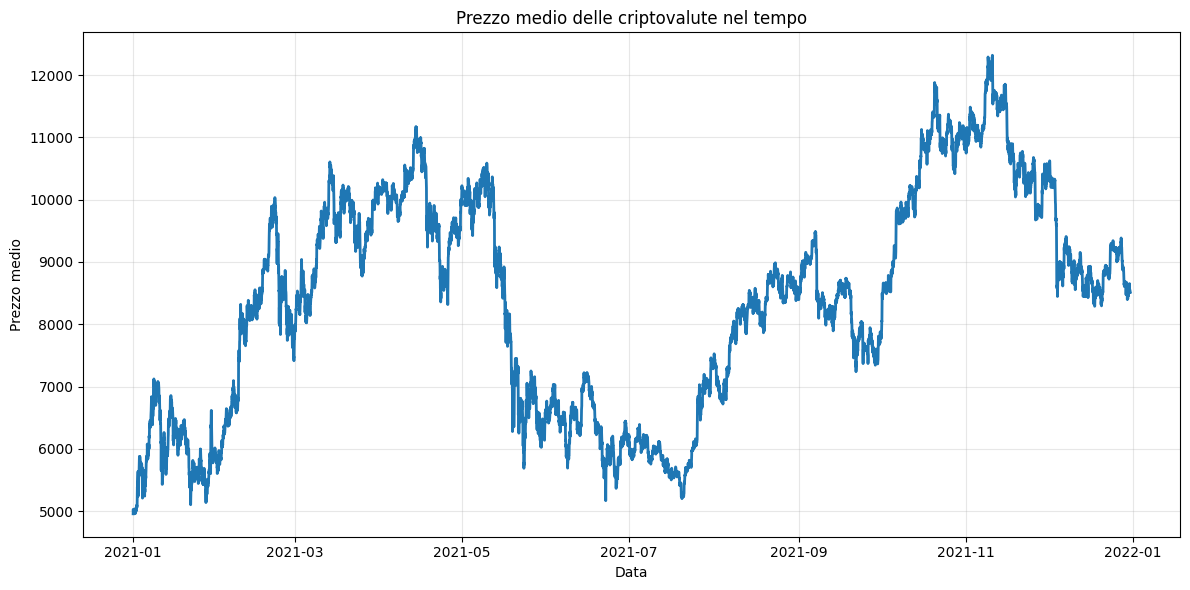

In [112]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices.mean(axis=1), label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [113]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [121]:
# Parametri fissi
initial_liquidity = 100

# Parametri variabili
timeframe = 24*7
timeframe_grid_search = -1 # un valore di -1 significa che diventa uguale a timeframe nella strategia; qui potrei anche mettere direttamente timeframe_grid_search=timeframe, ma in generale nella grid_search successiva devo fare così
mobile_window = 24*7
weighting_factor = 1
coef_liquidity_out = 5
coef_liquidity_in = 1
dynamical_variables = {
    'coef_liquidity_in': [0, 1, np.inf],
    'coef_liquidity_out': [0, 1, np.inf],
    # 'func_monitor': [mstd_returns_prices, ma_returns_prices],
    # 'mobile_window': [48, 24*7],
    # 'timeframe': [24, 24*7, 24*14],
    'weighting_factor': [0, 0.5, 1],
    # 'window_grid_search': [24*7, 24*14, 24*21]

} # VARIABILI DA NON METTERE IN dynamical_variables: dynamical_variables; timeframe_grid_search
window_grid_search = 24*15 # Consigliabile averlo maggiore di timeframe (se "timeframe" non compare in dynamical_variables), perchè altrimenti di fatto la grid search effettua delle mini-simulazioni in cui non ribilancia mai e il fattore di rendimento totale risulterà sempre uguale per tutte le combinazioni della grid search in questione
func_monitor = mstd_returns_prices

df_results = simulate_trading_strategy(crypto_prices, initial_liquidity, initial_allocations, timeframe, timeframe_grid_search, mobile_window, weighting_factor, coef_liquidity_out, coef_liquidity_in, dynamical_variables, window_grid_search, func_monitor)
df_results

Valore attuale del portafoglio totale: 149.06747156529218
temp_initial_allocations: {'liquidity': 0.0, 'BTC': 0.16666666666666669, 'ETH': 0.16666666666666669, 'SOL': 0.16666666666666669, 'DOGE': 0.16666666666666669, 'LINK': 0.16666666666666669, 'AXS': 0.16666666666666669}
Sto per fare la grid search del giorno 2021-01-08 00:00:00 (i=168)...

Inizio iterazione 1/27
Parametri: {'coef_liquidity_in': '0', 'coef_liquidity_out': '0', 'dynamical_variables': '{}', 'func_monitor': 'mstd_returns_prices', 'mobile_window': '168', 'timeframe': '168', 'timeframe_grid_search': '168', 'weighting_factor': '0', 'window_grid_search': '360'}
Iterazione 1 completata: Fattore Rendimento Totale = 1.531159829250231


Inizio iterazione 2/27
Parametri: {'coef_liquidity_in': '0', 'coef_liquidity_out': '0', 'dynamical_variables': '{}', 'func_monitor': 'mstd_returns_prices', 'mobile_window': '168', 'timeframe': '168', 'timeframe_grid_search': '168', 'weighting_factor': '0.5', 'window_grid_search': '360'}
Iterazion

,timestamp,liquidity,portfolio_value,avg_metric,sub_metric_up,sub_return_up,MA_sub_return_up,price_BTC,qty_BTC,value_BTC,metric_BTC,last_ext_type_BTC,last_ext_value_BTC,price_ETH,qty_ETH,value_ETH,metric_ETH,last_ext_type_ETH,last_ext_value_ETH,price_SOL,qty_SOL,value_SOL,metric_SOL,last_ext_type_SOL,last_ext_value_SOL,price_DOGE,qty_DOGE,value_DOGE,metric_DOGE,last_ext_type_DOGE,last_ext_value_DOGE,price_LINK,qty_LINK,value_LINK,metric_LINK,last_ext_type_LINK,last_ext_value_LINK,price_AXS,qty_AXS,value_AXS,metric_AXS,last_ext_type_AXS,last_ext_value_AXS,last_ext_type_avg,last_ext_value_avg,last_ext_type_sub_up,last_ext_value_sub_up
0,2021-01-01 00:00:00,0.0,100.000000,NaN,NaN,NaN,NaN,28995.13,0.000575,16.666667,NaN,None,NaN,734.07,0.022704,16.666667,NaN,None,NaN,1.5442,10.793075,16.666667,NaN,None,NaN,0.004679,3562.166937,16.666667,NaN,None,NaN,11.2812,1.477384,16.666667,NaN,None,NaN,0.53441,31.187041,16.666667,NaN,None,NaN,None,NaN,None,NaN
1,2021-01-01 01:00:00,0.0,101.342501,NaN,NaN,NaN,NaN,29409.99,0.000575,16.905132,NaN,None,NaN,748.28,0.022704,16.989297,NaN,None,NaN,1.5734,10.793075,16.981824,NaN,None,NaN,0.004737,3562.166937,16.872204,NaN,None,NaN,11.4735,1.477384,16.950768,NaN,None,NaN,0.53366,31.187041,16.643276,NaN,None,NaN,None,NaN,None,NaN
2,2021-01-01 02:00:00,0.0,101.477428,NaN,NaN,NaN,NaN,29194.65,0.000575,16.781353,NaN,None,NaN,744.06,0.022704,16.893484,NaN,None,NaN,1.5872,10.793075,17.130769,NaN,None,NaN,0.004755,3562.166937,16.938460,NaN,None,NaN,11.5773,1.477384,17.104120,NaN,None,NaN,0.53321,31.187041,16.629242,NaN,None,NaN,None,NaN,None,NaN
3,2021-01-01 03:00:00,0.0,102.659037,NaN,NaN,NaN,NaN,29278.40,0.000575,16.829493,NaN,None,NaN,744.82,0.022704,16.910740,NaN,None,NaN,1.6029,10.793075,17.300220,NaN,None,NaN,0.004978,3562.166937,17.732823,NaN,None,NaN,11.5006,1.477384,16.990805,NaN,None,NaN,0.54173,31.187041,16.894956,NaN,None,NaN,None,NaN,None,NaN
4,2021-01-01 04:00:00,0.0,102.115284,NaN,NaN,NaN,NaN,29220.31,0.000575,16.796102,NaN,None,NaN,742.29,0.022704,16.853297,NaN,None,NaN,1.6022,10.793075,17.292665,NaN,None,NaN,0.004894,3562.166937,17.432533,NaN,None,NaN,11.4575,1.477384,16.927130,NaN,None,NaN,0.53912,31.187041,16.813558,NaN,None,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2021-12-30 20:00:00,0.0,17223.657352,0.006885,0.006600,0.042699,0.012303,47203.16,0.047052,2221.012347,0.004785,min,0.004760,3724.78,0.695959,2592.293450,0.004822,min,0.004799,173.1900,19.334772,3348.589081,0.008020,max,0.008020,0.171100,15284.492320,2615.176636,0.007216,min,0.007205,19.8700,182.488740,3626.051260,0.009579,min,0.009579,95.08000,29.664857,2820.534577,0.006886,max,0.006886,max,0.006885,max,0.014336
8720,2021-12-30 21:00:00,0.0,17282.810113,0.006880,0.006338,-0.039814,0.011202,47300.00,0.047052,2225.568882,0.004787,min,0.004760,3736.93,0.695959,2600.749350,0.004829,min,0.004799,173.2000,19.334772,3348.782428,0.007974,min,0.007974,0.171800,15284.492320,2625.875781,0.007223,min,0.007205,19.9900,182.488740,3647.949909,0.009592,max,0.009592,95.53000,29.664857,2833.883763,0.006875,min,0.006875,max,0.006885,min,0.011202
8721,2021-12-30 22:00:00,0.0,17160.580139,0.006874,0.007444,0.174535,0.012241,47084.88,0.047052,2215.447014,0.004798,max,0.004798,3703.83,0.695959,2577.713113,0.004862,max,0.004862,171.6800,19.334772,3319.393576,0.007987,min,0.007974,0.171000,15284.492320,2613.648187,0.007225,max,0.007225,19.8600,182.488740,3624.226373,0.009472,max,0.009592,94.73000,29.664857,2810.151878,0.006900,min,0.006875,max,0.006885,max,0.012241
8722,2021-12-30 23:00:00,0.0,17204.612944,0.006859,0.007070,-0.050201,0.011942,47120.87,0.047052,2217.140422,0.004796,max,0.004798,3709.27,0.695959,2581.499129,0.004851,min,0.004851,172.5200,19.334772,3335.634784,0.007998,max,0.007998,0.171100,15284.492320,2615.176636,0.007149,max,0.007225,19.9300,182.488740,3637.00058

In [122]:
df_results['portfolio_value'].iloc[-1] / df_results['portfolio_value'].iloc[0]

171.73491953713545

In [123]:
df_results['portfolio_value'].max() / df_results['portfolio_value'].iloc[0]

280.20755378860616

In [124]:
df_results['portfolio_value'].max(), df_results['portfolio_value'].iloc[-1]

(28020.75537886061, 17173.49195371354)

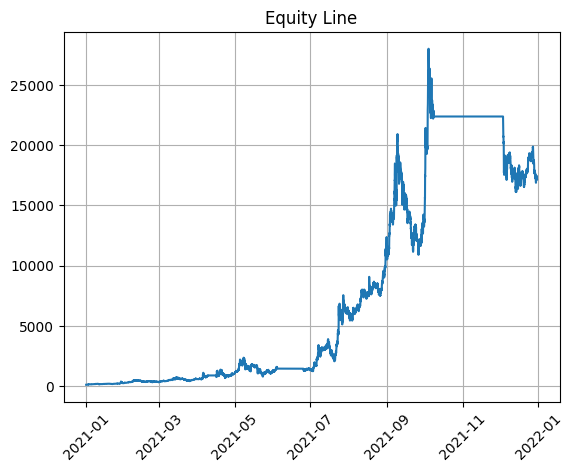

In [125]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(df_results['timestamp'], df_results['portfolio_value']);

In [126]:
mdp.calcola_principali_metriche(portfolio_values=df_results['portfolio_value'])

{'Total Return %': 17073.491953713547,
 'Max Drawdown %': 66.9242802153331,
 'Volatility': 0.3345222758934379,
 'Sharpe Ratio': 0.6071548979452658,
 'Sortino Ratio': 1.0597351865828164,
 'Calmar Ratio': 255.1165570818021,
 'Profit Factor': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti',
 'PnL': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti'}

In [120]:
calcola_rendimento_portafoglio_ideale_multicrypto([crypto_prices[crypto] for crypto in initial_allocations.keys() if crypto != 'liquidity'], initial_liquidity, [token_iniziali for token_iniziali in initial_allocations.values()], 0, 0, 0, 0)

[4.283913220607839e+59, 9.620487367455475e+61]

# Grid search

In [127]:
# Parametri fissi
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_liquidity = 100
sort_quantity = 'fattore_rendimento_totale'

In [ ]:
# Dizionario dei parametri per la grid search
param_grid = {
    'coef_liquidity_in': [1, 5],
    'coef_liquidity_out': [1, 5],
    'dynamical_variables': [{}, {'weighting_factor': [-1, 0, 1]}], # {'func_monitor': [ma_returns_prices, mstd_returns_prices]}, {'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf]}, {'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf], 'weighting_factor': [-1, 0, 1]}
    'func_monitor': [ma_returns_prices, mstd_returns_prices],
    'mobile_window': [48, 24*7, 24*14],
    'timeframe': [24*7, 24*14, 24*30],
    'timeframe_grid_search': [-1, 24, 24*7], # un valore di -1 significa che diventa uguale a timeframe nella strategia
    'weighting_factor': [0, 1],
    'window_grid_search': [24*15, 24*30]
}

# Genera tutte le combinazioni di parametri
grid_params = list(ParameterGrid(param_grid))

skip_conditions = [] # Qua salvo le condizioni per cui è inutile fare il calcolo perchè il risultato sarebbe uguale a un'altra combinazione già vista

for comb in grid_params:
    condition = len(comb['dynamical_variables']) == 0 and comb['window_grid_search'] != param_grid['window_grid_search'][0] or len(comb['dynamical_variables']) == 0 and comb['timeframe_grid_search'] != param_grid['timeframe_grid_search'][0] or any([param in comb['dynamical_variables'].keys() and comb[param] != param_grid[param][0] for param in param_grid.keys()]) # riguardo alla condizione con "any": se una variabile cambia dinamicamente, salto tutte le combinazioni in cui la stessa variabile in versione statica assume valori diversi dal primo, perchè tanto cambia dinamicamente quel parametro (in realtà non è del tutto uguale perchè all'inizio conta il valore iniziale del parametro, è solo dalla prima mini grid search che cambia in modo dinamico, ma considero trascurabile l'effetto)
    skip_conditions.append(condition)

# crypto_list = crypto_prices.columns

# Esegue la grid search e visualizza i nuovi risultati
risultati_df_ordinati = grid_search_rebalancing(crypto_prices, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity)
risultati_df_ordinati['func_monitor'] = risultati_df_ordinati['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else x
        )

print('risultati_df_ordinati:')
display(risultati_df_ordinati)


Inizio iterazione 1/1728
Parametri: {'coef_liquidity_in': '1', 'coef_liquidity_out': '1', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '48', 'timeframe': '168', 'timeframe_grid_search': '-1', 'weighting_factor': '0', 'window_grid_search': '360'}
Iterazione 1 completata: Fattore Rendimento Totale = 121.52752554529424


Inizio iterazione 2/1728
Parametri: {'coef_liquidity_in': '1', 'coef_liquidity_out': '1', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '48', 'timeframe': '168', 'timeframe_grid_search': '-1', 'weighting_factor': '0', 'window_grid_search': '720'}
Salto questa combinazione perchè sarebbe uguale a un'altra già vista...


Inizio iterazione 3/1728
Parametri: {'coef_liquidity_in': '1', 'coef_liquidity_out': '1', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '48', 'timeframe': '168', 'timeframe_grid_search': '-1', 'weighting_factor': '1', 'window_grid_search': '360'}

In [ ]:
# Converti eventuali colonne di tipo dict in stringa
for col in risultati_df_ordinati.columns:
    if risultati_df_ordinati[col].apply(lambda x: isinstance(x, dict)).any():
        risultati_df_ordinati[col] = risultati_df_ordinati[col].apply(lambda x: str(x))

# Carica i vecchi risultati dal file CSV
try:
    old_results = pd.read_csv('risultati_df_ordinati.csv')
except FileNotFoundError:
    old_results = pd.DataFrame()  # Crea un DataFrame vuoto se il file non esiste

# Concatena i vecchi e nuovi risultati, rimuovendo duplicati e reindicizzando
total_results = pd.concat([old_results, risultati_df_ordinati]).drop_duplicates().reset_index(drop=True)
print('total_results:')
display(total_results)

# Salva i risultati aggiornati nel file CSV senza l'indice
total_results.to_csv('risultati_df_ordinati.csv', index=False)

In [ ]:
# Verifico che non ci siano combinazioni di parametri uguali con risultati diversi (altrimenti ci sarebbe qualcosa di sbagliato): il value_counts sui soli parametri deve darmi tutti 1
total_results[param_grid.keys()].value_counts()

In [ ]:
total_results[(total_results['weighting_factor'] == 1) & (total_results['coef_liquidity_in'] == 5) & (total_results['coef_liquidity_out'] == 1)].sort_values(by='fattore_rendimento_totale', ascending=False)

In [ ]:
total_results[total_results['fattore_rendimento_totale'] > 100]

In [ ]:
total_results[total_results['fattore_rendimento_totale'] > 100][total_results[total_results['fattore_rendimento_totale'] > 100]['coef_liquidity_in'] > 9999]

In [ ]:
filtered_df = total_results[total_results['fattore_rendimento_totale'] > 100]
mean_values = filtered_df.select_dtypes(include=['number']).mean()
mean_values

In [ ]:
median_values = filtered_df.select_dtypes(include=['number']).median()
median_values

In [ ]:
total_results[:50]

In [ ]:
total_results[-50:]

In [ ]:
total_results['fattore_rendimento_totale'].mean(), total_results['fattore_rendimento_totale'].median(), total_results['fattore_rendimento_totale'].min(), total_results['fattore_rendimento_totale'].max(), total_results['fattore_rendimento_totale'].std()

In [ ]:
total_results.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

In [ ]:
total_results.sort_values(by='sortino_ratio', ascending=False).reset_index(drop=True)

In [ ]:
total_results.sort_values(by='calmar_ratio', ascending=False).reset_index(drop=True)

In [ ]:
total_results.sort_values(by='max_drawdown', ascending=True).reset_index(drop=True)

# Machine learning per trovare relazioni tra parametri e target

In [193]:
def train_random_forest_regressor(
    risultati_df_ordinati,
    feature_cols,
    target_col,
    test_size=0.2,
    random_state=42,
    # Parametri generici della RandomForest (valori di default)
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    # Valore numerico limite per sostituire np.inf
    max_val=1e9
):
    """
    Allena una RandomForestRegressor per predire 'target_col' (continuo) 
    a partire da 'feature_cols'. Sostituisce eventuali valori np.inf / -np.inf con +/- max_val.
    Mostra le importanze delle feature (anche graficamente).

    Parametri
    ---------
    risultati_df_ordinati : pd.DataFrame
        Il DataFrame con i dati (colonne di parametri e colonna target).
    feature_cols : list
        Lista di nomi di colonne da usare come feature (parametri).
    target_col : str
        Nome della colonna target (es. 'fattore_rendimento_totale').
    test_size : float
        Percentuale di dati nel test set (default 0.2 = 20%).
    random_state : int
        Seed per la riproducibilità.
    n_estimators : int
        Numero di alberi nella foresta. Default=100.
    criterion : str
        Funzione di split ('squared_error', 'absolute_error', ecc.).
    max_depth : int
        Profondità massima degli alberi, None = illimitata.
    min_samples_split : int
        Min numero di campioni per dividere un nodo.
    min_samples_leaf : int
        Min numero di campioni in un leaf node.
    min_weight_fraction_leaf : float
        Min frazione peso sample in un leaf node.
    max_features : str/int/float
        Numero di feature da considerare a ogni split.
    max_leaf_nodes : int
        Numero massimo di leaf nodes.
    min_impurity_decrease : float
        Soglia per ridurre la crescita del nodo se non migliora l'impurity.
    bootstrap : bool
        Usa il bootstrap per il campionamento.
    oob_score : bool
        Se True, calcola lo score out-of-bag.
    n_jobs : int
        Numero di job in parallelo (None=1, -1=usa tutti i core).
    verbose : int
        Livello di verbosità.
    warm_start : bool
        Se True, riusa la soluzione dell'albero precedente per addestrare uno nuovo.
    ccp_alpha : float
        Parametro di complessità di potatura Minimal Cost-Complexity.
    max_samples : int/float
        Se bootstrap=True, numero o frazione di campioni da campionare a ogni albero.
    max_val : float
        Valore con cui sostituire np.inf e -np.inf.

    Ritorna
    -------
    model : RandomForestRegressor
        Il modello allenato.
    """
    # Sostituiamo np.inf e -np.inf con +/- max_val
    for col in feature_cols:
        risultati_df_ordinati[col] = risultati_df_ordinati[col].replace([float('inf')], max_val)
        risultati_df_ordinati[col] = risultati_df_ordinati[col].replace([-float('inf')], -max_val)

    # Selezioniamo le feature e il target
    X = risultati_df_ordinati[feature_cols]
    y = risultati_df_ordinati[target_col]

    # Suddivisione train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Inizializziamo il modello di Random Forest Regressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples
    )

    # Fit del modello
    model.fit(X_train, y_train)

    # Predizione sul test set
    y_pred = model.predict(X_test)

    # Metriche di valutazione
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"R^2 (test):  {r2:.4f}")
    print(f"RMSE (test): {rmse:.4f}")

    # Feature importances
    importances = model.feature_importances_
    importances_pct = 100.0 * (importances / importances.sum())

    feats_imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'importance_pct': importances_pct
    }).sort_values('importance', ascending=True)

    print("\nFeature Importances (valore assoluto e percentuale):")
    display(feats_imp.sort_values('importance', ascending=False))

    # Plot orizzontale delle importanze (percentuali)
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('Random Forest Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return model

In [194]:
def flatten_dynamical_variables(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Trasforma la colonna 'col_name' contenente un dizionario (potenzialmente con liste, funzioni, int, float...)
    in un insieme di colonne aggiuntive 'dyn_{key}'.

    - Se la chiave del dizionario corrisponde a:
        * None -> memorizziamo None
        * list -> la codifichiamo come stringa (es. "[1, inf]")
        * int/float -> la salviamo come float (sostituendo inf).
        * callable (function) -> usiamo val.__name__ come stringa
        * altrimenti -> str(val).
    - Se non esiste la chiave in un certo dizionario, mettiamo None.
    """
    
    all_keys = set()
    for dvar in df[col_name]:
        if isinstance(dvar, dict):
            all_keys.update(dvar.keys())

    flattened_rows = []
    for idx, dvar in df[col_name].items():
        if not isinstance(dvar, dict):
            dvar = {}
        row_dict = {}
        for k in all_keys:
            val = dvar.get(k, None)
            if val is None:
                row_dict[k] = None
            elif isinstance(val, list):
                row_dict[k] = str(val)
            elif isinstance(val, (int, float)):
                # Se e' un float "speciale" (inf), puoi gestirlo come float('inf') o altro
                row_dict[k] = float(val)
            elif callable(val):
                # Se e' una funzione, salviamo val.__name__
                row_dict[k] = val.__name__
            else:
                # Altrimenti, trasformiamo genericamente in stringa
                row_dict[k] = str(val)
        flattened_rows.append(row_dict)

    dyn_df = pd.DataFrame(flattened_rows, index=df.index)
    dyn_df = dyn_df.add_prefix("dyn_")

    df_out = pd.concat([df.drop(columns=[col_name]), dyn_df], axis=1)
    return df_out


# Esempio di pipeline
def run_training_with_dynamical_vars(risultati_df_ordinati):
    # 1) Flatten la colonna "dynamical_variables" => dyn_...
    df_flat = flatten_dynamical_variables(risultati_df_ordinati, 'dynamical_variables')

    # 2) Identifichiamo le colonne da codificare (quelle dyn_ che risultano object)
    cat_cols = [c for c in df_flat.columns if c.startswith("dyn_") and df_flat[c].dtype == object or c == 'func_monitor']

    # 3) OneHot encoding su tali colonne
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    arr_encoded = oh.fit_transform(df_flat[cat_cols].astype(str))
    oh_cols = oh.get_feature_names_out(cat_cols)
    df_enc = pd.DataFrame(arr_encoded, columns=oh_cols, index=df_flat.index)

    # 4) Concatenazione
    df_prep = pd.concat([df_flat.drop(columns=cat_cols), df_enc], axis=1)

    # 5) Scegliamo la lista finale di feature da passare al modello
    #    Escludiamo la colonna del target (e altri target secondari)
    target_col = 'fattore_rendimento_totale'
    target_cols = [
        'fattore_rendimento_totale', 'volatility', 'calmar_ratio',
        'sortino_ratio', 'sharpe_ratio', 'max_drawdown'
    ]
    feature_cols_prep = [c for c in df_prep.columns if c not in target_cols]

    # 6) Alleniamo il modello
    model = train_random_forest_regressor(
        risultati_df_ordinati=df_prep,
        feature_cols=feature_cols_prep,
        target_col=target_col,
        test_size=0.2,
        random_state=42,
        n_estimators=1000,
        max_depth=None,
        verbose=0,
        max_val=1e9
    )

    return model, df_prep

In [ ]:
model, df_prep = run_training_with_dynamical_vars(total_results)

In [ ]:
risultati_df_ordinati['dynamical_variables'][20]

In [ ]:
risultati_df_ordinati['dynamical_variables'].value_counts()